# Image classification: French cheeses

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Import dataset

In this notebook we use the dataset ```auto_dataset_cleaned```, which uses a script to automatically download images from the internet, that are then checked manually.


In [7]:

data_dir = pathlib.Path('data/auto_dataset_cleaned')
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg')))
print(f"Found {image_count} jpg and jpeg images.")

Found 1441 jpg and jpeg images.


## Create a tf.keras dataset

In [8]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 1441 files belonging to 6 classes.
Using 1297 files for training.
Found 1441 files belonging to 6 classes.
Using 144 files for validation.
Class names: ['Camembert de Normandie', 'Cantal', 'Emmenthal de Savoie', "Fourme d'Ambert", 'Fourme de Montbrison', 'Roquefort']


## Visualize the data

Here are the first nine images from the training dataset:

2021-11-04 00:13:03.077390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


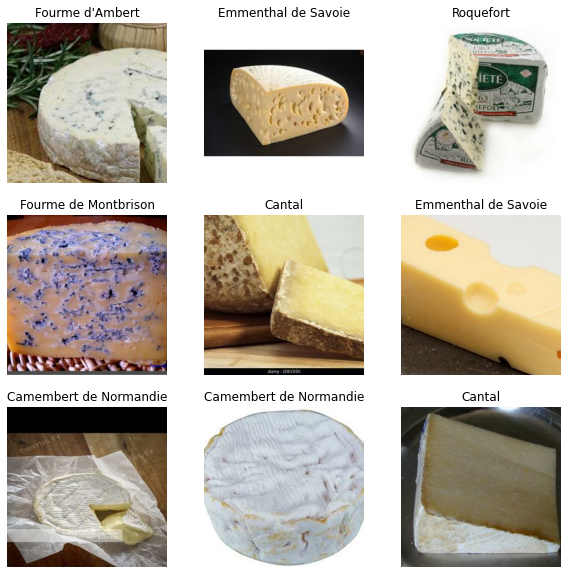

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [23]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)       

In [26]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
41/41 [==============================] - 46s 1s/step - loss: 2.2868 - accuracy: 0.2005 - val_loss: 1.7247 - val_accuracy: 0.2153
Epoch 2/15
41/41 [==============================] - 39s 963ms/step - loss: 1.6939 - accuracy: 0.2475 - val_loss: 1.5052 - val_accuracy: 0.2986
Epoch 3/15
41/41 [==============================] - 59s 1s/step - loss: 1.5102 - accuracy: 0.3369 - val_loss: 1.4907 - val_accuracy: 0.3264
Epoch 4/15
41/41 [==============================] - 53s 1s/step - loss: 1.4443 - accuracy: 0.3732 - val_loss: 1.3626 - val_accuracy: 0.4444
Epoch 5/15
41/41 [==============================] - 59s 1s/step - loss: 1.4005 - accuracy: 0.4017 - val_loss: 1.3635 - val_accuracy: 0.3750
Epoch 6/15
41/41 [==============================] - 58s 1s/step - loss: 1.3361 - accuracy: 0.4287 - val_loss: 1.3428 - val_accuracy: 0.4583
Epoch 7/15
41/41 [==============================] - 59s 1s/step - loss: 1.3178 - accuracy: 0.4618 - val_loss: 1.2369 - val_accuracy: 0.4792
Epoch 8/15
41/41 

## Visualize training results

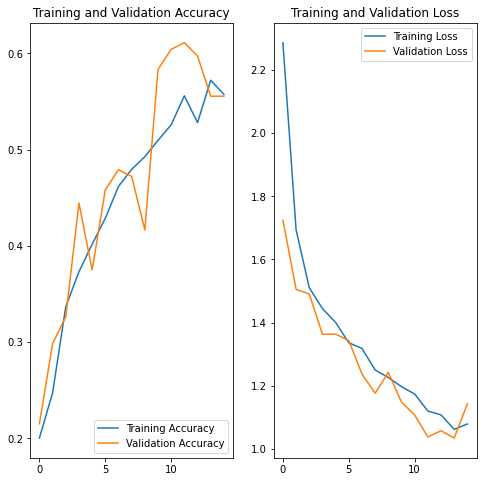

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [28]:
from IPython.display import display

def cheezam(filename : str):
    filepath = 'data/test/'+filename
    img = tf.keras.utils.load_img(filepath, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    display(PIL.Image.open(filepath))

    print(
    "This cheese is most likely a {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

    

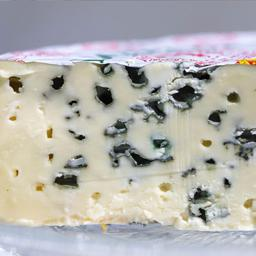

This cheese is most likely a Roquefort with a 67.21 percent confidence.


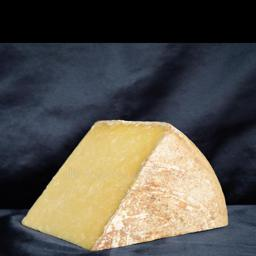

This cheese is most likely a Cantal with a 48.38 percent confidence.


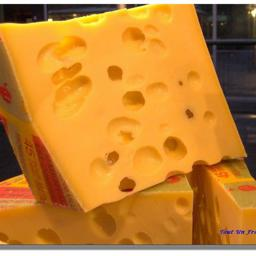

This cheese is most likely a Emmenthal de Savoie with a 79.75 percent confidence.


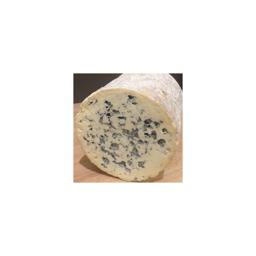

This cheese is most likely a Fourme d'Ambert with a 32.95 percent confidence.


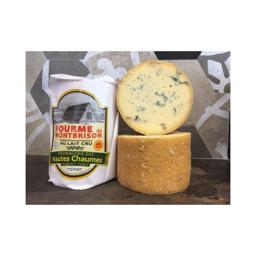

This cheese is most likely a Camembert de Normandie with a 29.02 percent confidence.


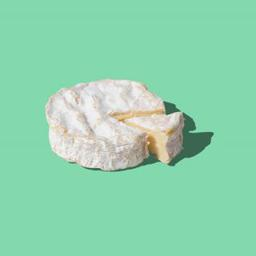

This cheese is most likely a Camembert de Normandie with a 57.94 percent confidence.


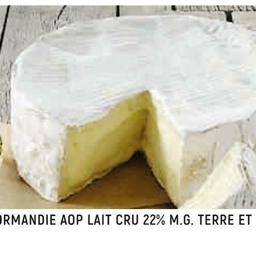

This cheese is most likely a Camembert de Normandie with a 40.68 percent confidence.


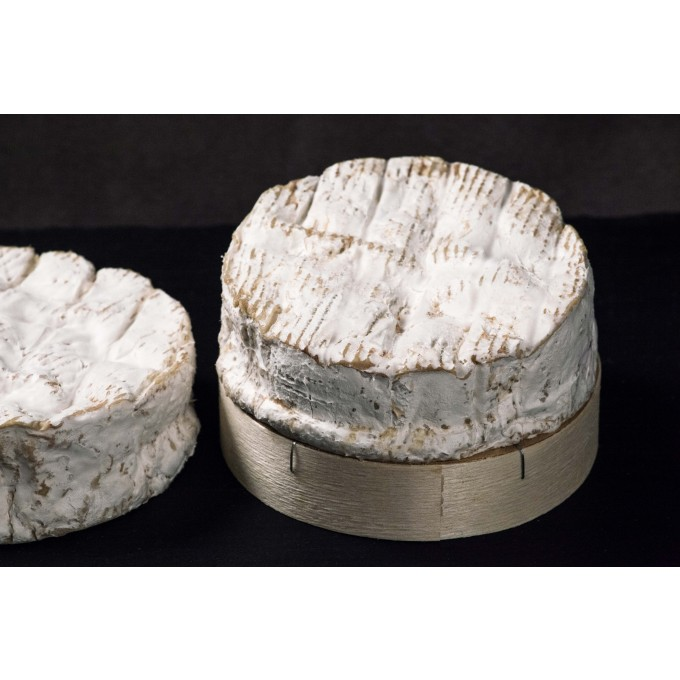

This cheese is most likely a Camembert de Normandie with a 75.39 percent confidence.


In [31]:
for i in range(1,9):
    cheezam('test'+str(i)+'.jpg')